In [6]:
import pandas as pd
import numpy as np
import os
import sys
from collections import Counter

In [5]:
def Pre_Sen(lst_true,lst_pre): 
    numOfAmbiguousTrue=0;  ##代表在某个level上，真实值的taxID没找到，赋值为-1
    numOfAmbiguousPredictionTrue=0  ##在某个level上，真实值和预测值的taxID都没找到，赋值为-1
    numOfUnClassified=0   ##没有分类的数量
    numOfCorrectAssign=0;
    numOfAssign=0;
    numOfAll=len(lst_true);
    for i in range(len(lst_true)):
        if(lst_true[i]==-1):
            numOfAmbiguousTrue=numOfAmbiguousTrue+1
        if(lst_true[i]==-1 and lst_pre[i]==-1):##代表没有答案
            numOfAmbiguousPredictionTrue=numOfAmbiguousPredictionTrue+1
            continue
        if(lst_pre[i]==0):
            numOfUnClassified=numOfUnClassified+1
        if(lst_pre[i]!=0 and lst_pre[i]==lst_true[i]):
            numOfCorrectAssign=numOfCorrectAssign+1
            numOfAssign=numOfAssign+1;
        if(lst_pre[i]!=0 and lst_pre[i]!=lst_true[i]):
            numOfAssign=numOfAssign+1;
    print("numOfAmbiguousTrue: "+str(numOfAmbiguousTrue))
    print("numOfAmbiguousPredictionTrue: "+str(numOfAmbiguousPredictionTrue))
    print("numOfUnClassified: "+str(numOfUnClassified))
    print("numOfCorrectAssign: "+str(numOfCorrectAssign))
    print("numOfAssign: "+str(numOfAssign))
    print("numOfAll: "+str(numOfAll))
    print("Precision: "+str(numOfCorrectAssign/numOfAssign))
    print("Sensitivity: "+str(numOfCorrectAssign/numOfAll))

## Get species level Dataframe

In [7]:
def get_species_df(new_df3):
    new_df5=new_df3.copy(deep=True)
    #统计species级别
    level="species"
    new_df5['true_species']=new_df5["true_taxid"].apply(lambda x: get_level(x,level))
    new_df5['clark_species']=new_df5["clark_id"].apply(lambda x: get_level(x,level))
    new_df5.insert(1,'clu_species',1)
    new_df5=new_df5.set_index('clusterid')
    print(new_df5.head())
    return new_df5

In [8]:
species_df=get_species_df(new_df3)

               readname  clu_species    labelid  true_taxid true_rank  \
clusterid                                                               
287052     S13R10000006            1   851733.0     1714682   species   
1841065    S13R10000016            1   182764.0        1599   species   
1669071    S13R10000026            1   463794.1        1587   species   
587753     S13R10000036            1  4378740.1      873513    strain   
353077     S13R10000046            1  4354103.0       89059   species   

           clark_id clark_rank  true_species  clark_species  
clusterid                                                    
287052     114090.0    species       1714682       114090.0  
1841065      1599.0    species          1599         1599.0  
1669071      1587.0    species          1587         1587.0  
587753          0.0        NaN         28126            0.0  
353077      89059.0    species         89059        89059.0  


In [9]:
def compute_result(new_df5): 
    lst_true=list(new_df5['true_species'])
    lst_kra=list(new_df5['clark_species'])
    print("============================Clark Speices Level Result Show==================================")
    Pre_Sen(lst_true,lst_kra)

In [11]:
compute_result(species_df)

============================Clark Speices Level Result Show==================================
numOfAmbiguousTrue: 620699
numOfAmbiguousPredictionTrue: 2
numOfUnClassified: 44729845
numOfCorrectAssign: 26101276
numOfAssign: 37549864
numOfAll: 82279711
Precision: 0.6951097346184796
Sensitivity: 0.3172261506849483


In [15]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (18,12)
from matplotlib_venn import venn2
def AnalysisSpecies_Clark(df,level):
    ##统计species的数量
    TrueSpcies=set(list(df["true_"+level]))
    KraSpecies=set(list(df["clark_"+level]))
    ##把kraken2的结果，取taxid 5条以上以上的分析
    TrueSpcies.discard(0)
    TrueSpcies.discard(-1)
    KraSpecies.discard(0)
    KraSpecies.discard(-1)
    numOfTrueSpecies=len(TrueSpcies) #数据集里真实species数量
    numOfKraSpecies=len(KraSpecies)  #预测的基于cluster的species的数量
    print("numOfTrueSpecies: "+str(numOfTrueSpecies))
    print("numOfClarkSpecies: "+str(numOfKraSpecies))
    ##画venn图
    venn2(subsets=[TrueSpcies,KraSpecies],set_labels=('True_'+level,'Kraken_'+level),set_colors=('r','g'))
    plt.show()

numOfTrueSpecies: 543
numOfClarkSpecies: 6682


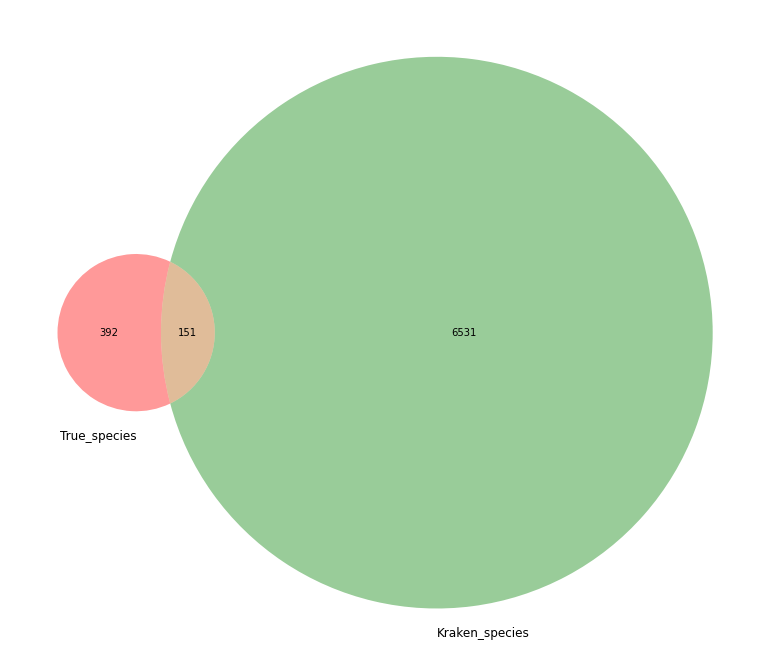

In [16]:
AnalysisSpecies_Clark(species_df,"species")

### save the dataframe , then use the databrick to group by clusterid to get the taxid of the cluster

In [12]:
species_df.to_csv("/home/ubuntu/clark/data/CAMI2_mouse_clark_tax_df.csv")  
print("finished")

finished


##  Taxid threshold in the cluster is set to 0.1

In [79]:
def compute_genus(new_df4):
    new_df4=new_df4.set_index('readname')
    df=new_df4[['true_genus','clu_genus', 'kra_genus', 'clusterid']]
    print(df.head())
    print(df.shape)
    lst_true=list(new_df4['true_genus'])
    lst_kra=list(new_df4['kra_genus'])
    lst_clu=list(new_df4['clu_genus'])
    print("=================================Kraken2 Genues Level Result Show=================================")
    Pre_Sen(lst_true,lst_kra)
    print("================================ LocalClustering Genues Level Result Show===============================")
    Pre_Sen(lst_true,lst_clu)

In [4]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)
from matplotlib_venn import venn3
def AnalysisSpecies(df,level):
    ##统计species的数量
    TrueSpcies=set(list(df["true_"+level]))
    CluSpecies=set(list(df["clu_"+level]))
    #KraSpecies=set(list(df["kra_"+level]))
    LstKraSpecies=list(df["kra_"+level])
    DictKraSpecies=dict(Counter(LstKraSpecies))
    KraSpecies=set()
    for key,val in DictKraSpecies.items():
        if(val>10):
            KraSpecies.add(key)
    ##把kraken2的结果，取taxid 5条以上以上的分析
    numOfTrueSpecies=len(TrueSpcies) #数据集里真实species数量
    numOfCluSpecies=len(CluSpecies)  #预测的基于cluster的species的数量
    numOfKraSpecies=len(KraSpecies)  #预测的基于cluster的species的数量
    print("numOfTrueSpecies: "+str(numOfTrueSpecies))
    print("numOfCluSpecies: "+str(numOfCluSpecies))
    print("numOfKraSpecies: "+str(numOfKraSpecies))
    ##画venn图
    venn3(subsets=[TrueSpcies,CluSpecies,KraSpecies],set_labels=('True_'+level,'Cluster_'+level,'Kraken_'+level),set_colors=('r','b','g'))
    plt.show()

In [86]:
compute_result("/home/ubuntu/tmp_share/Cami2_result.csv")

   clusterid     readname  clu_species   labelid  true_taxid true_rank  \
0       8602  S3R10167576         9606  999989.0     1235811    strain   
1       8602  S3R10400576         9606  999989.0     1235811    strain   
2       8602  S3R10540796         9606  999989.0     1235811    strain   
3       8602  S3R11061026         9606  999989.0     1235811    strain   
4       8602  S3R11180046         9606  999989.0     1235811    strain   

   kra_id kra_rank  true_species  kra_species  
0       0      NaN         28130            0  
1       0      NaN         28130            0  
2       0      NaN         28130            0  
3       0      NaN         28130            0  
4       0      NaN         28130            0  
(65007074, 10)
              true_taxid  true_species  clu_species  kra_id  clusterid
readname                                                              
S4R13225659       411485           853          853     853          0
S33R13669535      411485           853 

,clusterid,clu_species,labelid,true_taxid,true_rank,kra_id,kra_rank,true_species,kra_species
readname,,,,,,,,,
S3R10167576,8602,9606,999989.0,1235811,strain,0,NaN,28130,0
S3R10400576,8602,9606,999989.0,1235811,strain,0,NaN,28130,0
S3R10540796,8602,9606,999989.0,1235811,strain,0,NaN,28130,0
S3R11061026,8602,9606,999989.0,1235811,strain,0,NaN,28130,0
S3R11180046,8602,9606,999989.0,1235811,strain,0,NaN,28130,0
...,...,...,...,...,...,...,...,...,...
S58R11419440,196420,853,189840.0,411485,strain,853,species,853,853
S58R12259030,196420,853,189840.0,411485,strain,657322,strain,853,853
S58R14183900,196420,853,189840.0,411485,strain,853,species,853,853


In [12]:
! aws s3 cp s3://share.jgi-ga.org/chen-Tax/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.1/part-00000 tmp_share/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.1.csv

download: s3://share.jgi-ga.org/chen-Tax/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.1/part-00000 to tmp_share/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.1.csv


In [13]:
! head -n 5 tmp_share/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.1.csv

104878,S14R9924570,572511,184966.0,1796616,species,572511,genus,572511,572511
104878,S15R11362518,572511,184966.0,1796616,species,572511,genus,572511,572511
104878,S15R1325748,572511,184966.0,1796616,species,572511,genus,572511,572511
104878,S15R14170998,572511,184966.0,1796616,species,572511,genus,572511,572511
104878,S15R16367588,572511,184966.0,1796616,species,572511,genus,572511,572511


In [80]:
compute_genus(genus_df01)

              true_genus  clu_genus  kra_genus  clusterid
readname                                                 
S14R9924570       572511     572511     572511     104878
S15R11362518      572511     572511     572511     104878
S15R1325748       572511     572511     572511     104878
S15R14170998      572511     572511     572511     104878
S15R16367588      572511     572511     572511     104878
(65007074, 4)
=================================Kraken2 Genues Level Result Show=================================
numOfAmbiguousTrue: 2403251
numOfAmbiguousPredictionTrue: 73359
numOfUnClassified: 24677873
numOfCorrectAssign: 32403462
numOfAssign: 40255842
numOfAll: 65007074
Precision: 0.8049381255023805
Sensitivity: 0.4984605521546778
================================ LocalClustering Genues Level Result Show===============================
numOfAmbiguousTrue: 2403251
numOfAmbiguousPredictionTrue: 131409
numOfUnClassified: 17804611
numOfCorrectAssign: 34993412
numOfAssign: 47071054
numOfAll

In [65]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)
from matplotlib_venn import venn3
def AnalysisSpecies(df,level):
    ##统计species的数量
    TrueSpcies=set(list(df["true_"+level]))
    CluSpecies=set(list(df["clu_"+level]))
    #KraSpecies=set(list(df["kra_"+level]))
    LstKraSpecies=list(df["kra_"+level])
    DictKraSpecies=dict(Counter(LstKraSpecies))
    KraSpecies=set()
    for key,val in DictKraSpecies.items():
        if(val>10):
            KraSpecies.add(key)
    ##把kraken2的结果，取taxid 5条以上以上的分析
    numOfTrueSpecies=len(TrueSpcies) #数据集里真实species数量
    numOfCluSpecies=len(CluSpecies)  #预测的基于cluster的species的数量
    numOfKraSpecies=len(KraSpecies)  #预测的基于cluster的species的数量
    print("numOfTrueSpecies: "+str(numOfTrueSpecies))
    print("numOfCluSpecies: "+str(numOfCluSpecies))
    print("numOfKraSpecies: "+str(numOfKraSpecies))
    ##画venn图
    venn3(subsets=[TrueSpcies,CluSpecies,KraSpecies],set_labels=('True_'+level,'Cluster_'+level,'Kraken_'+level),set_colors=('r','b','g'))
    plt.show()

In [16]:
compute_genus(genus_df01)

              true_genus  clu_genus  kra_genus  clusterid
readname                                                 
S14R9924570       572511     572511     572511     104878
S15R11362518      572511     572511     572511     104878
S15R1325748       572511     572511     572511     104878
S15R14170998      572511     572511     572511     104878
S15R16367588      572511     572511     572511     104878
(65007074, 4)
=================================Kraken2 Genues Level Result Show=================================
numOfAmbiguousTrue: 2403251
numOfAmbiguousPredictionTrue: 73359
numOfUnClassified: 24677873
numOfCorrectAssign: 32403462
numOfAssign: 40255842
numOfAll: 65007074
Precision: 0.8049381255023805
Sensitivity: 0.4984605521546778
================================ LocalClustering Genues Level Result Show===============================
numOfAmbiguousTrue: 2403251
numOfAmbiguousPredictionTrue: 131409
numOfUnClassified: 17804611
numOfCorrectAssign: 34993412
numOfAssign: 47071054
numOfAll

numOfTrueSpecies: 542
numOfCluSpecies: 5528
numOfKraSpecies: 6709


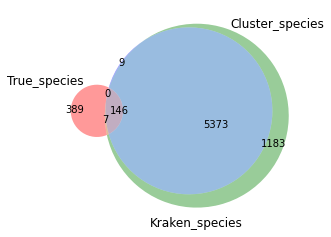

In [13]:
AnalysisSpecies(new_df5,"species")

numOfTrueSpecies: 178
numOfCluSpecies: 1682
numOfKraSpecies: 1850


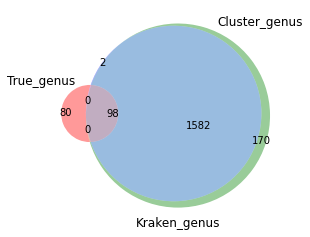

In [26]:
AnalysisSpecies(genus_df01,"genus")

## Taxid threshold in the cluster is set to 0.2

In [16]:
! aws s3 cp s3://share.jgi-ga.org/chen-Tax/CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.2/part-00000 Cami2_result_02.csv

download: s3://share.jgi-ga.org/chen-Tax/CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.2/part-00000 to ./Cami2_result_02.csv


In [37]:
! ls -l

total 13260976
-rw-rw-r--  1 ubuntu ubuntu          0 Aug  2 16:06 100readClusterResult.txt
-rw-rw-r--  1 ubuntu ubuntu  577996269 Feb 15  2018 Anaconda3-5.1.0-Linux-x86_64.sh
-rw-rw-r--  1 ubuntu ubuntu    1173859 Aug 16 13:25 Analysis-species-abundance-purity100-100clu-100read.ipynb
-rw-rw-r--  1 ubuntu ubuntu    1183774 Aug 23 16:33 Analysis-species-abundance-purity80-100clu-100read.ipynb
-rw-rw-r--  1 ubuntu ubuntu    1183940 Aug 23 16:33 Analysis-species-abundance-purity85-100clu-100read.ipynb
-rw-rw-r--  1 ubuntu ubuntu    1238998 Sep 13 12:03 Analysis-species-abundance-purity90-100clu-100read.ipynb
-rw-rw-r--  1 ubuntu ubuntu     772228 Sep 13 14:12 Analysis-species-abundance-purityunknown-all-localclustering-filter-8.22.ipynb
-rw-rw-r--  1 ubuntu ubuntu   10516866 Feb  3  2021 BBMap_38.90.tar.gz
-rw-rw-r--  1 ubuntu ubuntu    2099865 Aug 23 16:37 CAMI2_50Sample_local_compeleteness_purity_2021.8.3.ipynb
-rw-rw-r--  1 ubuntu ubuntu     334766 Aug  5 14:22 Cami2_Sample50_LocalClus

In [39]:
species_df02=pd.read_csv("Cami2_result_02.csv",header=None)
species_df02.columns=['clusterid','readname','clu_species','labelid','true_taxid','true_rank','kra_id','kra_rank','true_species','kra_species']
print(species_df02.head())
print(species_df02.shape)

   clusterid      readname  clu_species   labelid  true_taxid true_rank  \
0     165389  S14R10459810            0  259846.0     1855302   species   
1     165389  S14R11041510            0  259846.0     1855302   species   
2     165389  S14R11553890            0  259846.0     1855302   species   
3     165389   S14R2229260            0  730939.1     1520802   species   
4     165389   S14R3194670            0  259846.0     1855302   species   

   kra_id kra_rank  true_species  kra_species  
0       0      NaN       1855302            0  
1       0      NaN       1855302            0  
2       0      NaN       1855302            0  
3       0      NaN       1520802            0  
4       0      NaN       1855302            0  
(65007074, 10)


In [19]:
path="Cami2_result_02.csv"
result_df=compute_result(path)

   clusterid      readname  clu_species   labelid  true_taxid true_rank  \
0     165389  S14R10459810            0  259846.0     1855302   species   
1     165389  S14R11041510            0  259846.0     1855302   species   
2     165389  S14R11553890            0  259846.0     1855302   species   
3     165389   S14R2229260            0  730939.1     1520802   species   
4     165389   S14R3194670            0  259846.0     1855302   species   

   kra_id kra_rank  true_species  kra_species  
0       0      NaN       1855302            0  
1       0      NaN       1855302            0  
2       0      NaN       1855302            0  
3       0      NaN       1520802            0  
4       0      NaN       1855302            0  
(65007074, 10)
              true_taxid  true_species  clu_species  kra_id  clusterid
readname                                                              
S61R6993016       411485           853          853     853          0
S39R15134093      411485         

In [17]:
! aws s3 cp s3://share.jgi-ga.org/chen-Tax/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.2/part-00000 tmp_share/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.2.csv

download: s3://share.jgi-ga.org/chen-Tax/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.2/part-00000 to tmp_share/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.2.csv


In [18]:
genus_df02=pd.read_csv("tmp_share/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.2.csv",header=None)
genus_df02.columns=['clusterid','readname' , 'clu_genus', 'labelid'  ,'true_taxid', 'true_rank',  'kra_id', 'kra_rank',  'true_genus',  'kra_genus']
print(genus_df02.head())
print(genus_df02.shape)
compute_genus(genus_df02)

   clusterid      readname  clu_genus   labelid  true_taxid true_rank  kra_id  \
0     104878   S13R3720026     572511  184966.0     1796616   species  572511   
1     104878  S19R16312936     572511  184966.0     1796616   species  572511   
2     104878  S36R10363825     572511  184966.0     1796616   species  572511   
3     104878  S36R10823855     572511  184966.0     1796616   species  572511   
4     104878  S36R11685905     572511  184966.0     1796616   species  572511   

  kra_rank  true_genus  kra_genus  
0    genus      572511     572511  
1    genus      572511     572511  
2    genus      572511     572511  
3    genus      572511     572511  
4    genus      572511     572511  
(65007074, 10)
              true_genus  clu_genus  kra_genus  clusterid
readname                                                 
S13R3720026       572511     572511     572511     104878
S19R16312936      572511     572511     572511     104878
S36R10363825      572511     572511     572511    

numOfTrueSpecies: 542
numOfCluSpecies: 4835
numOfKraSpecies: 6709


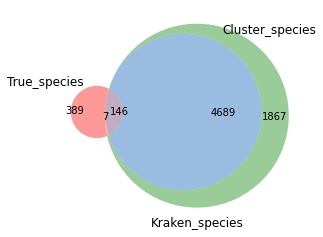

In [20]:
#0.2
AnalysisSpecies(result_df,"species")

numOfTrueSpecies: 178
numOfCluSpecies: 1553
numOfKraSpecies: 1850


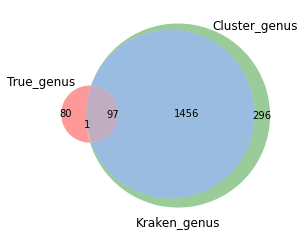

In [27]:
AnalysisSpecies(genus_df02,"genus")

## Taxid threshold in the cluster is set to 0.3

In [21]:
! aws s3 cp s3://share.jgi-ga.org/chen-Tax/CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.3/part-00000 Cami2_result_03.csv

download: s3://share.jgi-ga.org/chen-Tax/CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.3/part-00000 to ./Cami2_result_03.csv


In [2]:
species_df03=pd.read_csv("Cami2_result_03.csv",header=None)
species_df03.columns=['clusterid','readname','clu_species','labelid','true_taxid','true_rank','kra_id','kra_rank','true_species','kra_species']
print(species_df03.head())
print(species_df03.shape)

   clusterid      readname  clu_species   labelid  true_taxid true_rank  \
0     117295  S15R11004968         1587  463794.1        1587   species   
1     117295  S15R12229178         1587  463794.1        1587   species   
2     117295  S31R10309072         1587  463794.1        1587   species   
3     117295  S31R11275022         1587  463794.1        1587   species   
4     117295   S37R4380847         1587  171232.0     1226333    strain   

   kra_id kra_rank  true_species  kra_species  
0    1587  species          1587         1587  
1    1587  species          1587         1587  
2    1587  species          1587         1587  
3    1587  species          1587         1587  
4    1587  species          1587         1587  
(65007074, 10)


# To merge clusters based-on cluster,then assess the purity and completeness of big cluster 

In [75]:
import numpy as np
import pandas as pd
import os
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as numpy
import pandas as pd 
from imp import reload
from sklearn import  metrics

import sys
if not "/home/ubuntu/" in sys.path:
    sys.path.append("/home/ubuntu/")
if not 'function' in sys.modules:
    function = __import__('function')
else:
    eval('import function')
    function = eval('reload(function)')

## based-on cluster purity&completeness show  --species level

In [7]:
#species level purity
clusters_03=species_df03[['readname','clu_species']]
clusters_03.columns=['node','cluster']
label_03=species_df03[['readname','labelid']]
label_03.columns=['node','cluster']
print(clusters_03.head())
ret_03,new_df_03=analysize(label_03,clusters_03)

           node  cluster
0  S15R11004968     1587
1  S15R12229178     1587
2  S31R10309072     1587
3  S31R11275022     1587
4   S37R4380847     1587
{'Total #reads': 65007074, 'Total #clusters': 3241, 'ground #truth': 788, 'Filtered #clusters': 3241, 'Filtered #reads': 65007074, 'Filtered #ground_truth': 788, 'mean cluster size:': 20057.721073742672, 'median cluster size:': 230.0, '%100 purification:': 0.23295279234804073, '>%95 purification:': 0.4865782165998149, '>%90 purification:': 0.5640234495526072, 'mean purification:': 0.8171334201050954, 'median purification:': 0.9454545454545454, '>%80 purification:': 0.6282011724776304, '>%70 purification:': 0.6997840172786177, '>%60 purification:': 0.7886454797901882, '>%50 purification:': 0.8812095032397408, '>%40 purification:': 0.9441530391854366, '>%30 purification:': 0.9854983029929034, '>%20 purification:': 0.9978401727861771, '>%10 purification:': 1.0, '>%5  purification:': 1.0, '%100 completeness:': 0.005076142131979695, '>%90 comp

## global clustering result show

In [10]:
! aws s3 cp s3://zc-notebook/notebook/deal_data/CAMI2_data/global_data/ccaddseq_lpa3_global.csv ./mycami2/

download: s3://zc-notebook/notebook/deal_data/CAMI2_data/global_data/ccaddseq_lpa3_global.csv to mycami2/ccaddseq_lpa3_global.csv


In [72]:
! ls ../LocalClustering_Result_2021_8_zc/ccaddseq_local_filter.csv

LocalClusteringFilterRead_Braken.bracken
LocalClusteringFilterRead_Braken_genus.bracken
LocalClusteringFilterRead_Kraken_Braken.kraken2
LocalClusteringFilterRead_Kraken_Braken.kreport2
LocalClusteringFilterRead_Kraken_Braken_bracken.kreport2
ccaddseq_local_filter.csv
ccaddseq_local_nofilter.csv


In [77]:
#clusters=new_df3[['readname','clusterid']]
#clusters.columns=['node','cluster']
#print(clusters.head())
labelpath="/home/ubuntu/mycami2/label50sample"
cluster_local="/home/ubuntu/LocalClustering_Result_2021_8_zc/ccaddseq_local_filter.csv"
label=function.read_gt(labelpath)
clusters =  function.read_cluster(cluster_local)
print(clusters.head())
print(clusters.dtypes)
ret,df=function.analysize(label,clusters)

           node    cluster
0  S34R12990133   184925.0
1   S38R5736656   851733.0
2  S15R11522068   135956.0
3      S52R2547  4469576.0
4    S5R7760255   318732.0
1    83029581
Name: node, dtype: int64
           node  cluster
0  S61R13938276    73532
1   S18R2005129   353008
2  S40R11860275   288149
3  S64R12703515    37430
4   S44R1087909   220054
node       object
cluster     int64
dtype: object
{'Total #reads': 65007074, 'Total #clusters': 378915, 'ground #truth': 790, 'Filtered #clusters': 378915, 'Filtered #reads': 65007074, 'Filtered #ground_truth': 788, 'mean cluster size:': 171.56109945502288, 'median cluster size:': 124.0, '%100 purification:': 0.2954118997664384, '>%95 purification:': 0.6277898737183801, '>%90 purification:': 0.7182613514904398, 'mean purification:': 0.8851815540275305, 'median purification:': 0.9795918367346939, '>%80 purification:': 0.7978544000633387, '>%70 purification:': 0.8513281342781363, '>%60 purification:': 0.8927701463388886, '>%50 purification:': 

In [8]:
#clusters=new_df3[['readname','clusterid']]
#clusters.columns=['node','cluster']
#print(clusters.head())
labelpath="/home/ubuntu/mycami2/label50sample"
cluster_local="/home/ubuntu/mycami2/ccadddseq_lpa3_local_nofilter"
label=read_gt(labelpath)
clusters =  read_cluster(cluster_local)
print(clusters.head())
print(clusters.dtypes)
ret,df=analysize(label,clusters)

           node    cluster
0  S34R12990133   184925.0
1   S38R5736656   851733.0
2  S15R11522068   135956.0
3      S52R2547  4469576.0
4    S5R7760255   318732.0
1    83029581
Name: node, dtype: int64
           node  cluster
0   S15R3088938  1317522
1    S29R833853   858080
2   S22R4248249  1451522
3  S43R13936924  1988889
4    S9R3890864  1634424
node       object
cluster     int64
dtype: object
{'Total #reads': 82251260, 'Total #clusters': 2018980, 'ground #truth': 790, 'Filtered #clusters': 2018980, 'Filtered #reads': 82251260, 'Filtered #ground_truth': 790, 'mean cluster size:': 40.739016731220715, 'median cluster size:': 7.0, '%100 purification:': 0.6543878592160398, '>%95 purification:': 0.7219120546018286, '>%90 purification:': 0.7641388225737749, 'mean purification:': 0.9129484543415519, 'median purification:': 1.0, '>%80 purification:': 0.8251929191968221, '>%70 purification:': 0.8669843188144508, '>%60 purification:': 0.9184806189263885, '>%50 purification:': 0.9699481916611

In [11]:
labelpath="/home/ubuntu/mycami2/label50sample"
cluster_local="/home/ubuntu/mycami2/ccaddseq_lpa3_global.csv"
label=read_gt(labelpath)
clusters =  read_cluster(cluster_local)
print(clusters.head())
print(clusters.dtypes)
ret,df=analysize(label,clusters)

           node    cluster
0  S34R12990133   184925.0
1   S38R5736656   851733.0
2  S15R11522068   135956.0
3      S52R2547  4469576.0
4    S5R7760255   318732.0
1    83029581
Name: node, dtype: int64
           node  cluster
0   S21R6095326    13501
1   S46R1412220     7814
2  S13R13521386     2959
3   S31R9627142     2030
4  S32R10798704     9485
node       object
cluster     int64
dtype: object
{'Total #reads': 60875311, 'Total #clusters': 15058, 'ground #truth': 790, 'Filtered #clusters': 15058, 'Filtered #reads': 60875311, 'Filtered #ground_truth': 789, 'mean cluster size:': 4042.7222074644706, 'median cluster size:': 144.0, '%100 purification:': 0.25043166423163765, '>%95 purification:': 0.4490636206667552, '>%90 purification:': 0.5466197370168681, 'mean purification:': 0.7902723236547838, 'median purification:': 0.9254988767014669, '>%80 purification:': 0.6402576703413468, '>%70 purification:': 0.6945809536459026, '>%60 purification:': 0.754217027493691, '>%50 purification:': 0.

## compare based-cluster and global clustering

In [60]:
#species level purity
clusters_03=species_df03[['readname','clu_species']]
clusters_03.columns=['node','cluster']
label_03=species_df03[['readname','labelid']]
label_03.columns=['node','cluster']
print(clusters_03.head())
ret_03,new_df_03=analysize(label_03,clusters_03)

labelpath="/home/ubuntu/mycami2/label50sample"
cluster_local="/home/ubuntu/mycami2/ccaddseq_lpa3_global.csv"
label=read_gt(labelpath)
clusters =  read_cluster(cluster_local)
print(clusters.head())
print(clusters.dtypes)
ret,df=analysize(label,clusters)

           node  cluster
0  S15R11004968     1587
1  S15R12229178     1587
2  S31R10309072     1587
3  S31R11275022     1587
4   S37R4380847     1587
{'Total #reads': 65007074, 'Total #clusters': 3241, 'ground #truth': 788, 'Filtered #clusters': 3241, 'Filtered #reads': 65007074, 'Filtered #ground_truth': 788, 'mean cluster size:': 20057.721073742672, 'median cluster size:': 230.0, '%100 purification:': 0.23295279234804073, '>%95 purification:': 0.4865782165998149, '>%90 purification:': 0.5640234495526072, 'mean purification:': 0.8171334201050954, 'median purification:': 0.9454545454545454, '>%80 purification:': 0.6282011724776304, '>%70 purification:': 0.6997840172786177, '>%60 purification:': 0.7886454797901882, '>%50 purification:': 0.8812095032397408, '>%40 purification:': 0.9441530391854366, '>%30 purification:': 0.9854983029929034, '>%20 purification:': 0.9978401727861771, '>%10 purification:': 1.0, '>%5  purification:': 1.0, '%100 completeness:': 0.005076142131979695, '>%90 comp

In [61]:
dfLocal=new_df_03.copy()
dfGlobal=df.copy()

In [62]:
print(dfLocal.head())
print(dfGlobal.head())

   cid      rname  count  c_count  r_count  purification  completeness
0   -1  1033413.0    159  5048924      840      0.000031      0.189286
1   -1    10512.0    141  5048924      688      0.000028      0.204942
2   -1    10518.0     47  5048924      684      0.000009      0.068713
3   -1   110016.0     25  5048924      727      0.000005      0.034388
4   -1  1105328.0    212  5048924     1773      0.000042      0.119571
   cid         rname  count  c_count  r_count  purification  completeness
0    0     1107303.0    442      824   334889      0.536408      0.001320
1    0      132338.0      1      824      899      0.001214      0.001112
2    0      178480.0      6      824    17262      0.007282      0.000348
3    0      245324.1    372      824   320001      0.451456      0.001162
4    0  denovo2333.0      1      824     1575      0.001214      0.000635


In [63]:
df_local_purity=dfLocal.groupby(['cid'])[['c_count','purification']].max().reset_index().sort_values('c_count',ascending=False)
df_local_completeness=dfLocal.groupby(['rname'])[['r_count','completeness']].max().reset_index().sort_values('r_count',ascending=False)
df_global_purity=dfGlobal.groupby(['cid'])[['c_count','purification']].max().reset_index().sort_values('c_count',ascending=False)
df_global_completeness=dfGlobal.groupby(['rname'])[['r_count','completeness']].max().reset_index().sort_values('r_count',ascending=False)
#merge=[df_local_purity['purification']*100,df_global_purity['purification']*100,\
#df_local_completeness['completeness']*100,df_global_completeness['completeness']*100]
merge=[df_local_completeness['completeness']*100,df_global_completeness['completeness']*100,\
      df_local_purity['purification']*100,df_global_purity['purification']*100]

In [64]:
def percent(values):
    fake=list(sort(values))
    SUM=float(reduce(lambda x,y:x+y,fake))
    j=0
    thd=np.power(10,np.linspace(1.69,7,54))
   # thd=[100,1000,10000,100000,1000000,10000000]
    pcd = [[0] * len(fake) for i in range(len(thd))]
    alist=[]
    for i in np.arange(len(fake)):
        if thd[j]<=fake[i]<thd[j+1]:
            pcd[j].append(fake[i])
        else:
            j=j+1
            pcd[j].append(fake[i])
    for j in np.arange(len(thd)):
        alist.append(sum(pcd[j])/SUM*100)
    return alist
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')
        rect.set_edgecolor('white')

In [65]:
##Local vs Global
#fname="Local vs Global"
def plot_figure2(merge,df_local_purity,df_global_purity):
    fname="Based-Cluster vs Global"
    bins=50
    alpha=1
    localcolor='darkgray'
    globalcolor='dimgray'
    fig1 = plt.figure(num=1, figsize=(12, 12), dpi=600)
    plt.subplots_adjust( wspace=.1, hspace=.1 )
    if 1:
        ax2=plt.subplot(3,1,1)
       # ax2.set_title('Cluster size comparison',fontsize=16)
        ax2.set_ylabel("% of clusters",fontsize=14) 
        ax2.set_xlabel("cluster size(log10)",fontsize=14)  
        values=percent(df_local_purity['c_count'].values)
        local= ax2.bar(np.arange(len(values)),values,color=localcolor,alpha=alpha,label='Based-Cluster') 

        values=percent(df_global_purity['c_count'].values)
        Global= ax2.bar(np.arange(len(values)),values,color=globalcolor,alpha=alpha,label='Global')
        plt.legend(loc='best',fontsize=14)
        scale_ls = np.arange(len(values))
        index_ls = [' ',' ',' ',
                   '2',' ',' ',' ',' ',' ',' ',' ',' ',' ',
                   '3',' ',' ',' ',' ',' ',' ',' ',' ',' ',
                   '4',' ',' ',' ',' ',' ',' ',' ',' ',' ',
                   '5',' ',' ',' ',' ',' ',' ',' ',' ',' ',
                   '6',' ',' ',' ',' ',' ',' ',' ',' ',' ',
                   '7']
        plt.xticks(scale_ls,index_ls)  ## 可以设置坐标字
    plt.tight_layout();
    fig1.savefig(fname + '.pdf', format='pdf') 
    plt.show()

In [66]:
plot_figure2(merge,df_local_purity,df_global_purity)

In [67]:
##Local vs Global
#fname="Local vs Global"
def plt_figure1(merge):
    fname="Based-Cluster vs Global"
    bins=50
    alpha=1
    localcolor='darkgray'
    globalcolor='dimgray'
    fig1 = plt.figure(num=1, figsize=(12, 12), dpi=600)
    plt.subplots_adjust( wspace=.1, hspace=.1 )
    if 2:
        ax1=plt.subplot(3,1,2)
        medianprops = dict(linestyle='-', linewidth=3, color='black')
        sns.violinplot(data=merge,width=0.9,inner=None,color="w", scale='width')
        bplot=boxplot(merge,showfliers=False,positions=[0,1,2,3],patch_artist = True,widths=0.10,medianprops =medianprops)

       # ax1.set_title('Performance comparison',fontsize=16)
        ax1.set_xlabel("cluster purity and completeness distribution",fontsize=14)  
        colors = [localcolor, globalcolor, localcolor, globalcolor,localcolor, globalcolor]#颜色填充
        for patch, color in zip(bplot['boxes'], colors):patch.set_facecolor(color)      
        ax1.tick_params(labelsize=12)
        plt.setp(ax1, xticks=[0.5,2.5,4.5],xticklabels=['completeness','purity','       '])
        ax1.legend([bplot["boxes"][0], bplot["boxes"][1]], ['Based-cluster', 'Global'],bbox_to_anchor=(0.5, 1.0),fontsize=14)   #图例 
    plt.tight_layout();
    fig1.savefig(fname + '.pdf', format='pdf') 
    plt.show()

In [68]:
plt_figure1(merge)

In [38]:
    label_path='/home/ubuntu/mycami2/label50sample'
    path='/home/ubuntu/mycami2/genomes/'
    files= os.listdir(path) #得到文件夹下的所有文件名称
    s = {}
    for file in files: #遍历文件夹
         if not os.path.isdir(file): #判断是否是文件夹，不是文件夹才打开
            f = open(path+"/"+file); #打开文件
            iter_f = iter(f); #创建迭代器
            sum=0
            i=1
            for line in iter_f: #遍历文件，一行行遍历，读取文本
                if i%2==0:
                    sum+=len(line)
                i=i+1
            s[file]=sum
    table1=pd.DataFrame(s,index=[0]).T.reset_index()
    table1.columns=['join_id','length']
    table2=pd.read_csv('/home/ubuntu/mycami2/genome_to_id.tsv',header=None, sep="\t")
    table2.columns=['id','join_id']
    t1=table2['join_id'].map(lambda x: x.split('/')[7])
    table2=pd.concat([t1,table2['id']], axis=1)
    table=pd.merge(table1,table2,on=['join_id'])[['id','length']]
    
    label=pd.read_csv(label_path,header=None, sep="\t")
    label.columns=['rname','id']
    temp=label.groupby('id').size()
    temp=pd.DataFrame(temp).reset_index()
    temp.columns=['id','size']

    merge=pd.merge(table.astype(object),temp.astype(object),on=['id'])[['id','length','size']]
    merge=merge[merge['length']>0]
    #merge=merge[merge['size']*10>merge['length']]
    merge['coverage']=merge['size']*300/merge['length']
    merge.columns=['rname','length','size','coverage']

In [42]:
def genome(dfGlobal):
    '''
    return purity>95% & completeness>80% information
    '''
    df1=dfGlobal.loc[dfGlobal.groupby(['cid'])['count'].idxmax()]
    df1=df1.reset_index().sort_values('c_count',ascending=False)[['count','c_count','purification','r_count','completeness','rname']].head(30)
    print ("Top 30 cluster: ")
    display(df1)
    #completeness
    df2=dfGlobal.loc[dfGlobal.groupby(['rname'])['count'].idxmax()]
    df2[df2['completeness']>=0.8].reset_index().sort_values('r_count',ascending=False)[['count','c_count','purification','r_count','completeness','rname']]
    temp=pd.merge(merge,df2,on=['rname'])[['rname','length','size','coverage','completeness','count','c_count','purification']]
    temp1=temp[temp['coverage']>=10]
    df2=temp1[temp1['completeness']>=0.8]
    temp1[temp1['completeness']>=0.8].sort_values('c_count',ascending=False)[['count','c_count','purification','size','completeness','rname','length','coverage']]
    df3=dfGlobal[((dfGlobal['purification']>=0.95) & (dfGlobal['completeness']>=0.8))]
    df4=dfGlobal[((dfGlobal['purification']>=0.95) & (dfGlobal['completeness']>=0.7))]
    df5=dfGlobal[((dfGlobal['purification']>=0.9) & (dfGlobal['completeness']>=0.8))]
    df6=dfGlobal[((dfGlobal['purification']>=0.9) & (dfGlobal['completeness']>=0.7))]
    df7=dfGlobal[((dfGlobal['purification']>=0.85) & (dfGlobal['completeness']>=0.8))]
    df8=dfGlobal[((dfGlobal['purification']>=0.85) & (dfGlobal['completeness']>=0.7))]
    df9=dfGlobal[((dfGlobal['purification']>=0.8) & (dfGlobal['completeness']>=0.8))]
    df10=dfGlobal[((dfGlobal['purification']>=0.8) & (dfGlobal['completeness']>=0.7))]
    df11=dfGlobal[((dfGlobal['purification']>=0.7) & (dfGlobal['completeness']>=0.8))]
    df12=dfGlobal[((dfGlobal['purification']>=0.7) & (dfGlobal['completeness']>=0.7))]
    print ("only completeness>80%:")
    print (len(df2))
    display(df2)
    print ("purity>95% & completeness>80%:")
    print (len(df3))
    display(df3)
    print ("only purity>95% & completeness>70%:")
    print (len(df4))
    display(df4)
    print ("only purity>90% & completeness>88%:")
    print (len(df5))
    display(df5)
    print ("only purity>90% & completeness>70%:")
    print (len(df6))
    display(df6)
    print ("only purity>85% & completeness>80%:")
    print (len(df7))
    display(df7)
    print ("only purity>85% & completeness>70%:")
    print (len(df8))
    display(df8)
    print ("only purity>80% & completeness>80%:")
    print (len(df9))
    display(df9)
    print ("only purity>80% & completeness>70%:")
    print (len(df10))
    display(df10)
    print ("only purity>70% & completeness>80%:")
    print (len(df11))
    display(df11)
    print ("only purity>70% & completeness>70%:")
    print (len(df12))
    display(df12)

In [43]:
genome(dfGlobal)

Top 30 cluster: 


,count,c_count,purification,r_count,completeness,rname
2030,5006394,6865298,0.729232,5029338,0.995438,4378740.0
1132,6504427,6624168,0.981924,6514410,0.998468,851733.0
13262,4989211,5602374,0.890553,5006056,0.996635,135956.0
8756,3358720,3499184,0.959858,3380555,0.993541,318732.0
7688,1726007,2880098,0.599288,1774850,0.972480,304047.0
14398,2250575,2782074,0.808956,2263908,0.994111,460611.0
5489,1917954,2383770,0.804589,1929495,0.994019,4424327.0
14674,2264271,2318563,0.976584,2264551,0.999876,4306262.0
2959,937393,2245310,0.417489,1206032,0.777254,47365.0
6034,2089110,2244616,0.930720,2109329,0.990414,999989.0


only completeness>80%:
26


,rname,length,size,coverage,completeness,count,c_count,purification
40,4469576.0,3540263,1788460,151.553,0.989890,1763868,1870947,0.942767
129,4449518.0,3734240,1412560,113.482,0.982775,1337847,1503849,0.889615
185,4340358.0,5491453,204654,11.1803,0.915221,152333,2880098,0.052892
227,1108599.0,4628540,782815,50.7384,0.969473,701905,748972,0.937158
236,318732.0,6627518,3387718,153.348,0.993541,3358720,3499184,0.959858
242,4424327.0,4400443,1939291,132.211,0.994019,1917954,2383770,0.804589
258,336277.0,3861332,451662,35.0912,0.846613,282684,325129,0.869452
304,136604.0,4315218,498256,34.6395,0.861182,390335,2782074,0.140304
323,135956.0,2788853,5008940,538.817,0.996635,4989211,5602374,0.890553
419,181719.0,5310992,1088459,61.4834,0.910581,832114,2880098,0.288919


purity>95% & completeness>80%:
5


,cid,rname,count,c_count,r_count,purification,completeness
13399,1132,851733.0,6504427,6624168,6514410,0.981924,0.998468
66111,6191,192222.0,1731783,1754536,1734705,0.987032,0.998316
94002,8756,318732.0,3358720,3499184,3380555,0.959858,0.993541
141507,13501,1684221.0,2156124,2193105,2158747,0.983138,0.998785
154678,14674,4306262.0,2264271,2318563,2264551,0.976584,0.999876


only purity>95% & completeness>70%:
5


,cid,rname,count,c_count,r_count,purification,completeness
13399,1132,851733.0,6504427,6624168,6514410,0.981924,0.998468
66111,6191,192222.0,1731783,1754536,1734705,0.987032,0.998316
94002,8756,318732.0,3358720,3499184,3380555,0.959858,0.993541
141507,13501,1684221.0,2156124,2193105,2158747,0.983138,0.998785
154678,14674,4306262.0,2264271,2318563,2264551,0.976584,0.999876


only purity>90% & completeness>88%:
8


,cid,rname,count,c_count,r_count,purification,completeness
11762,1047,4469576.0,1763868,1870947,1781883,0.942767,0.989890
13399,1132,851733.0,6504427,6624168,6514410,0.981924,0.998468
63623,6034,999989.0,2089110,2244616,2109329,0.930720,0.990414
66111,6191,192222.0,1731783,1754536,1734705,0.987032,0.998316
94002,8756,318732.0,3358720,3499184,3380555,0.959858,0.993541
141507,13501,1684221.0,2156124,2193105,2158747,0.983138,0.998785
146413,13986,1108599.0,701905,748972,724007,0.937158,0.969473
154678,14674,4306262.0,2264271,2318563,2264551,0.976584,0.999876


only purity>90% & completeness>70%:
8


,cid,rname,count,c_count,r_count,purification,completeness
11762,1047,4469576.0,1763868,1870947,1781883,0.942767,0.989890
13399,1132,851733.0,6504427,6624168,6514410,0.981924,0.998468
63623,6034,999989.0,2089110,2244616,2109329,0.930720,0.990414
66111,6191,192222.0,1731783,1754536,1734705,0.987032,0.998316
94002,8756,318732.0,3358720,3499184,3380555,0.959858,0.993541
141507,13501,1684221.0,2156124,2193105,2158747,0.983138,0.998785
146413,13986,1108599.0,701905,748972,724007,0.937158,0.969473
154678,14674,4306262.0,2264271,2318563,2264551,0.976584,0.999876


only purity>85% & completeness>80%:
11


,cid,rname,count,c_count,r_count,purification,completeness
11762,1047,4469576.0,1763868,1870947,1781883,0.942767,0.989890
13399,1132,851733.0,6504427,6624168,6514410,0.981924,0.998468
27234,2454,4449518.0,1337847,1503849,1361295,0.889615,0.982775
62597,5982,336277.0,282684,325129,333900,0.869452,0.846613
63623,6034,999989.0,2089110,2244616,2109329,0.930720,0.990414
66111,6191,192222.0,1731783,1754536,1734705,0.987032,0.998316
94002,8756,318732.0,3358720,3499184,3380555,0.959858,0.993541
138488,13262,135956.0,4989211,5602374,5006056,0.890553,0.996635
141507,13501,1684221.0,2156124,2193105,2158747,0.983138,0.998785
146413,13986,1108599.0,701905,748972,724007,0.937158,0.969473


only purity>85% & completeness>70%:
11


,cid,rname,count,c_count,r_count,purification,completeness
11762,1047,4469576.0,1763868,1870947,1781883,0.942767,0.989890
13399,1132,851733.0,6504427,6624168,6514410,0.981924,0.998468
27234,2454,4449518.0,1337847,1503849,1361295,0.889615,0.982775
62597,5982,336277.0,282684,325129,333900,0.869452,0.846613
63623,6034,999989.0,2089110,2244616,2109329,0.930720,0.990414
66111,6191,192222.0,1731783,1754536,1734705,0.987032,0.998316
94002,8756,318732.0,3358720,3499184,3380555,0.959858,0.993541
138488,13262,135956.0,4989211,5602374,5006056,0.890553,0.996635
141507,13501,1684221.0,2156124,2193105,2158747,0.983138,0.998785
146413,13986,1108599.0,701905,748972,724007,0.937158,0.969473


only purity>80% & completeness>80%:
14


,cid,rname,count,c_count,r_count,purification,completeness
11762,1047,4469576.0,1763868,1870947,1781883,0.942767,0.989890
13399,1132,851733.0,6504427,6624168,6514410,0.981924,0.998468
27234,2454,4449518.0,1337847,1503849,1361295,0.889615,0.982775
56941,5489,4424327.0,1917954,2383770,1929495,0.804589,0.994019
62597,5982,336277.0,282684,325129,333900,0.869452,0.846613
63623,6034,999989.0,2089110,2244616,2109329,0.930720,0.990414
66111,6191,192222.0,1731783,1754536,1734705,0.987032,0.998316
72203,6803,190114.0,283678,339209,321586,0.836293,0.882122
94002,8756,318732.0,3358720,3499184,3380555,0.959858,0.993541
138488,13262,135956.0,4989211,5602374,5006056,0.890553,0.996635


only purity>80% & completeness>70%:
14


,cid,rname,count,c_count,r_count,purification,completeness
11762,1047,4469576.0,1763868,1870947,1781883,0.942767,0.989890
13399,1132,851733.0,6504427,6624168,6514410,0.981924,0.998468
27234,2454,4449518.0,1337847,1503849,1361295,0.889615,0.982775
56941,5489,4424327.0,1917954,2383770,1929495,0.804589,0.994019
62597,5982,336277.0,282684,325129,333900,0.869452,0.846613
63623,6034,999989.0,2089110,2244616,2109329,0.930720,0.990414
66111,6191,192222.0,1731783,1754536,1734705,0.987032,0.998316
72203,6803,190114.0,283678,339209,321586,0.836293,0.882122
94002,8756,318732.0,3358720,3499184,3380555,0.959858,0.993541
138488,13262,135956.0,4989211,5602374,5006056,0.890553,0.996635


only purity>70% & completeness>80%:
17


,cid,rname,count,c_count,r_count,purification,completeness
11762,1047,4469576.0,1763868,1870947,1781883,0.942767,0.989890
13399,1132,851733.0,6504427,6624168,6514410,0.981924,0.998468
21721,2030,4378740.0,5006394,6865298,5029338,0.729232,0.995438
23471,2163,164237.0,401257,553632,442370,0.724772,0.907062
27234,2454,4449518.0,1337847,1503849,1361295,0.889615,0.982775
56941,5489,4424327.0,1917954,2383770,1929495,0.804589,0.994019
62597,5982,336277.0,282684,325129,333900,0.869452,0.846613
63623,6034,999989.0,2089110,2244616,2109329,0.930720,0.990414
66111,6191,192222.0,1731783,1754536,1734705,0.987032,0.998316
72203,6803,190114.0,283678,339209,321586,0.836293,0.882122


only purity>70% & completeness>70%:
17


,cid,rname,count,c_count,r_count,purification,completeness
11762,1047,4469576.0,1763868,1870947,1781883,0.942767,0.989890
13399,1132,851733.0,6504427,6624168,6514410,0.981924,0.998468
21721,2030,4378740.0,5006394,6865298,5029338,0.729232,0.995438
23471,2163,164237.0,401257,553632,442370,0.724772,0.907062
27234,2454,4449518.0,1337847,1503849,1361295,0.889615,0.982775
56941,5489,4424327.0,1917954,2383770,1929495,0.804589,0.994019
62597,5982,336277.0,282684,325129,333900,0.869452,0.846613
63623,6034,999989.0,2089110,2244616,2109329,0.930720,0.990414
66111,6191,192222.0,1731783,1754536,1734705,0.987032,0.998316
72203,6803,190114.0,283678,339209,321586,0.836293,0.882122


In [44]:
genome(dfLocal)

Top 30 cluster: 


,count,c_count,purification,r_count,completeness,rname
1,4895282,25202482,0.194238,6512384,0.751688,851733.0
0,990023,5048924,0.196086,5004577,0.197824,135956.0
348,3940063,3999260,0.985198,5004577,0.787292,135956.0
150,1850077,3212610,0.575880,1859877,0.994731,304047.0
343,1434108,2903892,0.493857,1507244,0.951477,463794.1
157,1769829,2364764,0.748417,2271395,0.779182,460611.0
1231,2194894,2229391,0.984526,2262000,0.970333,4306262.0
160,1732271,1767872,0.979862,1732550,0.999839,192222.0
1382,1726509,1736764,0.994095,2161290,0.798833,1684221.0
1191,1300400,1393240,0.933364,1408056,0.923543,4449518.0


only completeness>80%:
50


,rname,length,size,coverage,completeness,count,c_count,purification
57,2897325.0,3544282,203760,17.2469,0.864334,12277,25202482,0.000487
68,831301.0,2127578,101887,14.3666,0.839468,13251,25202482,0.000526
70,168984.0,4438186,348291,23.5428,0.896703,281631,25202482,0.011175
93,1108453.0,3642477,213609,17.5932,0.836572,24110,25202482,0.000957
98,4480176.0,3050713,224738,22.1002,0.923925,54118,25202482,0.002147
99,312322.0,2340211,104661,13.4169,0.975189,79711,868746,0.091754
100,1111580.0,3177776,175853,16.6015,0.862021,9390,25202482,0.000373
129,4449518.0,3734240,1412560,113.482,0.923543,1300400,1393240,0.933364
131,190673.0,2353521,79404,10.1215,0.983576,74080,868746,0.085272
185,4340358.0,5491453,204654,11.1803,0.920110,171757,3212610,0.053463


purity>95% & completeness>80%:
7


,cid,rname,count,c_count,r_count,purification,completeness
5078,839,192222.0,1732271,1767872,1732550,0.979862,0.999839
6706,1264,187223.0,309358,325166,312541,0.951385,0.989816
11963,1601,169106.0,926534,938812,1147990,0.986922,0.807092
12705,1610,187233.0,567270,593436,628444,0.955908,0.902658
23446,89059,4354103.0,736143,747371,838924,0.984977,0.877485
28993,239935,4306262.0,2194894,2229391,2262000,0.984526,0.970333
30325,267818,47365.0,1057576,1089981,1236522,0.970270,0.855283


only purity>95% & completeness>70%:
9


,cid,rname,count,c_count,r_count,purification,completeness
5078,839,192222.0,1732271,1767872,1732550,0.979862,0.999839
6706,1264,187223.0,309358,325166,312541,0.951385,0.989816
10863,1597,135956.0,3940063,3999260,5004577,0.985198,0.787292
11963,1601,169106.0,926534,938812,1147990,0.986922,0.807092
12705,1610,187233.0,567270,593436,628444,0.955908,0.902658
23446,89059,4354103.0,736143,747371,838924,0.984977,0.877485
28993,239935,4306262.0,2194894,2229391,2262000,0.984526,0.970333
30325,267818,47365.0,1057576,1089981,1236522,0.970270,0.855283
32374,345370,1684221.0,1726509,1736764,2161290,0.994095,0.798833


only purity>90% & completeness>88%:
10


,cid,rname,count,c_count,r_count,purification,completeness
5078,839,192222.0,1732271,1767872,1732550,0.979862,0.999839
6706,1264,187223.0,309358,325166,312541,0.951385,0.989816
11963,1601,169106.0,926534,938812,1147990,0.986922,0.807092
12705,1610,187233.0,567270,593436,628444,0.955908,0.902658
23446,89059,4354103.0,736143,747371,838924,0.984977,0.877485
24278,105841,192777.0,472701,499880,523231,0.945629,0.903427
28204,214856,4449518.0,1300400,1393240,1408056,0.933364,0.923543
28993,239935,4306262.0,2194894,2229391,2262000,0.984526,0.970333
29800,253239,405780.0,44398,47094,45966,0.942753,0.965888
30325,267818,47365.0,1057576,1089981,1236522,0.970270,0.855283


only purity>90% & completeness>70%:
12


,cid,rname,count,c_count,r_count,purification,completeness
5078,839,192222.0,1732271,1767872,1732550,0.979862,0.999839
6706,1264,187223.0,309358,325166,312541,0.951385,0.989816
10863,1597,135956.0,3940063,3999260,5004577,0.985198,0.787292
11963,1601,169106.0,926534,938812,1147990,0.986922,0.807092
12705,1610,187233.0,567270,593436,628444,0.955908,0.902658
23446,89059,4354103.0,736143,747371,838924,0.984977,0.877485
24278,105841,192777.0,472701,499880,523231,0.945629,0.903427
28204,214856,4449518.0,1300400,1393240,1408056,0.933364,0.923543
28993,239935,4306262.0,2194894,2229391,2262000,0.984526,0.970333
29800,253239,405780.0,44398,47094,45966,0.942753,0.965888


only purity>85% & completeness>80%:
12


,cid,rname,count,c_count,r_count,purification,completeness
5078,839,192222.0,1732271,1767872,1732550,0.979862,0.999839
6706,1264,187223.0,309358,325166,312541,0.951385,0.989816
11563,1599,182764.0,249579,286576,265973,0.870900,0.938362
11963,1601,169106.0,926534,938812,1147990,0.986922,0.807092
12705,1610,187233.0,567270,593436,628444,0.955908,0.902658
19515,36874,187028.0,77101,88299,88568,0.873181,0.870529
23446,89059,4354103.0,736143,747371,838924,0.984977,0.877485
24278,105841,192777.0,472701,499880,523231,0.945629,0.903427
28204,214856,4449518.0,1300400,1393240,1408056,0.933364,0.923543
28993,239935,4306262.0,2194894,2229391,2262000,0.984526,0.970333


only purity>85% & completeness>70%:
14


,cid,rname,count,c_count,r_count,purification,completeness
5078,839,192222.0,1732271,1767872,1732550,0.979862,0.999839
6706,1264,187223.0,309358,325166,312541,0.951385,0.989816
10863,1597,135956.0,3940063,3999260,5004577,0.985198,0.787292
11563,1599,182764.0,249579,286576,265973,0.870900,0.938362
11963,1601,169106.0,926534,938812,1147990,0.986922,0.807092
12705,1610,187233.0,567270,593436,628444,0.955908,0.902658
19515,36874,187028.0,77101,88299,88568,0.873181,0.870529
23446,89059,4354103.0,736143,747371,838924,0.984977,0.877485
24278,105841,192777.0,472701,499880,523231,0.945629,0.903427
28204,214856,4449518.0,1300400,1393240,1408056,0.933364,0.923543


only purity>80% & completeness>80%:
14


,cid,rname,count,c_count,r_count,purification,completeness
5078,839,192222.0,1732271,1767872,1732550,0.979862,0.999839
6706,1264,187223.0,309358,325166,312541,0.951385,0.989816
8682,1515,denovo8298.0,14580,17468,16863,0.834669,0.864615
11563,1599,182764.0,249579,286576,265973,0.870900,0.938362
11963,1601,169106.0,926534,938812,1147990,0.986922,0.807092
12705,1610,187233.0,567270,593436,628444,0.955908,0.902658
19515,36874,187028.0,77101,88299,88568,0.873181,0.870529
23446,89059,4354103.0,736143,747371,838924,0.984977,0.877485
24278,105841,192777.0,472701,499880,523231,0.945629,0.903427
24846,109790,318764.0,45431,53851,49572,0.843643,0.916465


only purity>80% & completeness>70%:
16


,cid,rname,count,c_count,r_count,purification,completeness
5078,839,192222.0,1732271,1767872,1732550,0.979862,0.999839
6706,1264,187223.0,309358,325166,312541,0.951385,0.989816
8682,1515,denovo8298.0,14580,17468,16863,0.834669,0.864615
10863,1597,135956.0,3940063,3999260,5004577,0.985198,0.787292
11563,1599,182764.0,249579,286576,265973,0.870900,0.938362
11963,1601,169106.0,926534,938812,1147990,0.986922,0.807092
12705,1610,187233.0,567270,593436,628444,0.955908,0.902658
19515,36874,187028.0,77101,88299,88568,0.873181,0.870529
23446,89059,4354103.0,736143,747371,838924,0.984977,0.877485
24278,105841,192777.0,472701,499880,523231,0.945629,0.903427


only purity>70% & completeness>80%:
15


,cid,rname,count,c_count,r_count,purification,completeness
5078,839,192222.0,1732271,1767872,1732550,0.979862,0.999839
5707,853,189840.0,339651,473903,377484,0.716710,0.899776
6706,1264,187223.0,309358,325166,312541,0.951385,0.989816
8682,1515,denovo8298.0,14580,17468,16863,0.834669,0.864615
11563,1599,182764.0,249579,286576,265973,0.870900,0.938362
11963,1601,169106.0,926534,938812,1147990,0.986922,0.807092
12705,1610,187233.0,567270,593436,628444,0.955908,0.902658
19515,36874,187028.0,77101,88299,88568,0.873181,0.870529
23446,89059,4354103.0,736143,747371,838924,0.984977,0.877485
24278,105841,192777.0,472701,499880,523231,0.945629,0.903427


only purity>70% & completeness>70%:
19


,cid,rname,count,c_count,r_count,purification,completeness
4082,831,460611.0,1769829,2364764,2271395,0.748417,0.779182
5078,839,192222.0,1732271,1767872,1732550,0.979862,0.999839
5707,853,189840.0,339651,473903,377484,0.716710,0.899776
6706,1264,187223.0,309358,325166,312541,0.951385,0.989816
8682,1515,denovo8298.0,14580,17468,16863,0.834669,0.864615
10863,1597,135956.0,3940063,3999260,5004577,0.985198,0.787292
11563,1599,182764.0,249579,286576,265973,0.870900,0.938362
11963,1601,169106.0,926534,938812,1147990,0.986922,0.807092
12705,1610,187233.0,567270,593436,628444,0.955908,0.902658
19515,36874,187028.0,77101,88299,88568,0.873181,0.870529


In [22]:
path03="Cami2_result_03.csv"
result_df03=compute_result(path03)

   clusterid      readname  clu_species   labelid  true_taxid true_rank  \
0     117295  S15R11004968         1587  463794.1        1587   species   
1     117295  S15R12229178         1587  463794.1        1587   species   
2     117295  S31R10309072         1587  463794.1        1587   species   
3     117295  S31R11275022         1587  463794.1        1587   species   
4     117295   S37R4380847         1587  171232.0     1226333    strain   

   kra_id kra_rank  true_species  kra_species  
0    1587  species          1587         1587  
1    1587  species          1587         1587  
2    1587  species          1587         1587  
3    1587  species          1587         1587  
4    1587  species          1587         1587  
(65007074, 10)
              true_taxid  true_species  clu_species  kra_id  clusterid
readname                                                              
S47R983232        411485           853          853     853          0
S44R6792649       411485         

In [19]:
! aws s3 cp s3://share.jgi-ga.org/chen-Tax/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.3/part-00000 tmp_share/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.3.csv

download: s3://share.jgi-ga.org/chen-Tax/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.3/part-00000 to tmp_share/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.3.csv


In [22]:
genus_df03=pd.read_csv("tmp_share/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.3.csv",header=None)
genus_df03.columns=['clusterid','readname' , 'clu_genus', 'labelid'  ,'true_taxid', 'true_rank',  'kra_id', 'kra_rank',  'true_genus',  'kra_genus']
print(genus_df03.head())
print(genus_df03.shape)
compute_genus(genus_df03)

   clusterid     readname  clu_genus   labelid  true_taxid true_rank  kra_id  \
0      27120  S44R2800409        838  192222.0         839   species     839   
1      27120  S44R3036849        838  192222.0         839   species     839   
2      27120  S44R4988909        838  192222.0         839   species     839   
3      27120  S44R5894919        838  192222.0         839   species  264731   
4      27120  S44R8120399        838  192222.0         839   species     839   

  kra_rank  true_genus  kra_genus  
0  species         838        838  
1  species         838        838  
2  species         838        838  
3   strain         838        838  
4  species         838        838  
(65007074, 10)
             true_genus  clu_genus  kra_genus  clusterid
readname                                                
S44R2800409         838        838        838      27120
S44R3036849         838        838        838      27120
S44R4988909         838        838        838      27120
S44

numOfTrueSpecies: 542
numOfCluSpecies: 3241
numOfKraSpecies: 6709


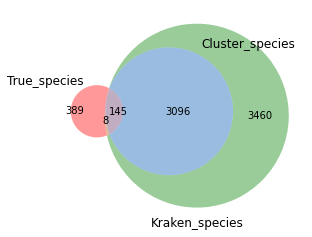

In [23]:
#0.3
AnalysisSpecies(result_df03,"species")

numOfTrueSpecies: 178
numOfCluSpecies: 1244
numOfKraSpecies: 1850


/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


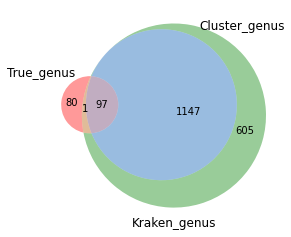

In [28]:
AnalysisSpecies(genus_df03,"genus")

## Taxid threshold in the cluster is set to 0.4

In [24]:
! aws s3 cp s3://share.jgi-ga.org/chen-Tax/CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.4/part-00000 Cami2_result_04.csv

download: s3://share.jgi-ga.org/chen-Tax/CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.4/part-00000 to ./Cami2_result_04.csv


In [41]:
species_df04=pd.read_csv("Cami2_result_04.csv",header=None)
species_df04.columns=['clusterid','readname','clu_species','labelid','true_taxid','true_rank','kra_id','kra_rank','true_species','kra_species']
print(species_df04.head())
print(species_df04.shape)

   clusterid      readname  clu_species   labelid  true_taxid true_rank  \
0     359876   S13R1042036         1610  187233.0     1423822    strain   
1     359876   S13R1065736         1610  187233.0     1423822    strain   
2     359876  S13R11076096         1610  187233.0     1423822    strain   
3     359876  S13R13524526         1610  187233.0     1423822    strain   
4     359876  S13R13652236         1610  187233.0     1423822    strain   

    kra_id kra_rank  true_species  kra_species  
0  1423822   strain          1610         1610  
1  1423822   strain          1610         1610  
2     1610  species          1610         1610  
3  1423822   strain          1610         1610  
4  1423822   strain          1610         1610  
(65007074, 10)


In [25]:
path04="Cami2_result_04.csv"
result_df04=compute_result(path04)

   clusterid      readname  clu_species   labelid  true_taxid true_rank  \
0     359876   S13R1042036         1610  187233.0     1423822    strain   
1     359876   S13R1065736         1610  187233.0     1423822    strain   
2     359876  S13R11076096         1610  187233.0     1423822    strain   
3     359876  S13R13524526         1610  187233.0     1423822    strain   
4     359876  S13R13652236         1610  187233.0     1423822    strain   

    kra_id kra_rank  true_species  kra_species  
0  1423822   strain          1610         1610  
1  1423822   strain          1610         1610  
2     1610  species          1610         1610  
3  1423822   strain          1610         1610  
4  1423822   strain          1610         1610  
(65007074, 10)
              true_taxid  true_species  clu_species  kra_id  clusterid
readname                                                              
S63R10940069      411485           853          853     853          0
S38R12855046      411485   

In [21]:
! aws s3 cp s3://share.jgi-ga.org/chen-Tax/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.4/part-00000 tmp_share/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.4.csv

download: s3://share.jgi-ga.org/chen-Tax/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.4/part-00000 to tmp_share/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.4.csv


In [23]:
genus_df04=pd.read_csv("tmp_share/Genus_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_0.4.csv",header=None)
genus_df04.columns=['clusterid','readname' , 'clu_genus', 'labelid'  ,'true_taxid', 'true_rank',  'kra_id', 'kra_rank',  'true_genus',  'kra_genus']
print(genus_df04.head())
print(genus_df04.shape)
compute_genus(genus_df04)

   clusterid      readname  clu_genus    labelid  true_taxid true_rank  \
0     245165  S14R11690300    2719313   259511.0      999405    strain   
1     245165   S14R2287470    2719313  3919797.0      999404    strain   
2     245165   S14R6386720    2719313   259511.0      999405    strain   
3     245165   S14R6973600    2719313   259511.0      999405    strain   
4     245165  S17R12191810    2719313   259511.0      999405    strain   

   kra_id kra_rank  true_genus  kra_genus  
0    1531  species     2719313    2719313  
1  208479  species     2719313    2719313  
2    1531  species     2719313    2719313  
3  186803   family     2719313         -1  
4  186803   family     2719313         -1  
(65007074, 10)
              true_genus  clu_genus  kra_genus  clusterid
readname                                                 
S14R11690300     2719313    2719313    2719313     245165
S14R2287470      2719313    2719313    2719313     245165
S14R6386720      2719313    2719313    27193

numOfTrueSpecies: 542
numOfCluSpecies: 2053
numOfKraSpecies: 6709


/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


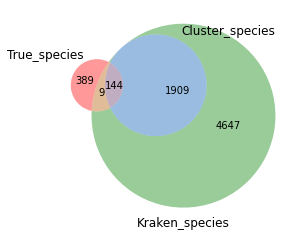

In [26]:
#0.4
AnalysisSpecies(result_df04,"species")

numOfTrueSpecies: 178
numOfCluSpecies: 933
numOfKraSpecies: 1850


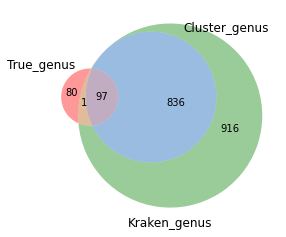

In [29]:
AnalysisSpecies(genus_df04,"genus")

## 2021-10-27; assign the taxid of clusters with the high percent of taxid, excluding 0 

In [58]:
! aws s3 cp s3://share.jgi-ga.org/chen-Tax/CAMI1_NonZero_1027/Species_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_Unzero_08/part-00000 /home/ubuntu/CAMI2_Real_Test/Species_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_Unzero_08 

download: s3://share.jgi-ga.org/chen-Tax/CAMI1_NonZero_1027/Species_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_Unzero_08/part-00000 to ./Species_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_Unzero_08


In [64]:
path08="Species_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_Unzero_08"
result_df08=compute_result(path08)

   clusterid     readname  clu_species   labelid  true_taxid true_rank  \
0     221108  S15R2554308            0  197875.0      742723   species   
1     221108  S15R3329368            0  197875.0      742723   species   
2     221108  S15R4190538            0  197875.0      742723   species   
3     221108  S15R5444998            0  197875.0      742723   species   
4     221108  S15R7061928            0  197875.0      742723   species   

   kra_id kra_rank  true_species  kra_species  
0       0      NaN        742723            0  
1       0      NaN        742723            0  
2       0      NaN        742723            0  
3       0      NaN        742723            0  
4       0      NaN        742723            0  
(65007074, 10)
              true_taxid  true_species  clu_species  kra_id  clusterid
readname                                                              
S22R3874579       411485           853          853     853          0
S46R2618450       411485           853 

numOfTrueSpecies: 542
numOfCluSpecies: 5903
numOfKraSpecies: 6709


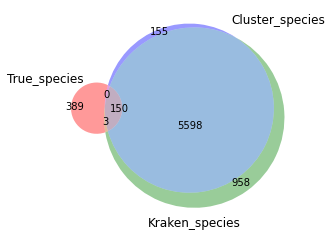

In [66]:
AnalysisSpecies(result_df08,"species")

In [67]:
! aws s3 cp s3://share.jgi-ga.org/chen-Tax/CAMI1_NonZero_1027/Species_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_Unzero_008/part-00000 /home/ubuntu/CAMI2_Real_Test/Species_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_Unzero_008 

download: s3://share.jgi-ga.org/chen-Tax/CAMI1_NonZero_1027/Species_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_Unzero_008/part-00000 to ./Species_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_Unzero_008


   clusterid      readname  clu_species   labelid  true_taxid true_rank  \
0      15488  S15R10036438          853  304080.0         853   species   
1      15488  S15R11466048          853  189840.0      411485    strain   
2      15488   S33R9569625          853  189840.0      411485    strain   
3      15488   S33R9751065          853  189840.0      411485    strain   
4      15488   S46R3885050          853  269378.0         853   species   

   kra_id kra_rank  true_species  kra_species  
0  657322   strain           853          853  
1  657322   strain           853          853  
2  657322   strain           853          853  
3  657322   strain           853          853  
4  657322   strain           853          853  
(65007074, 10)
              true_taxid  true_species  clu_species  kra_id  clusterid
readname                                                              
S61R6993016       411485           853          853     853          0
S39R5683593       411485         

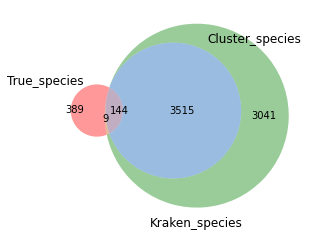

In [68]:
path008="Species_CAMI2_localclustering_filter_cluster_kraken2_taxonomy_Unzero_008"
result_df008=compute_result(path008)
AnalysisSpecies(result_df008,"species")

In [69]:
clusterset=set(list(result_df008['clusterid']))
print(len(clusterset))

378915


## 0.95

In [2]:
! aws s3 cp s3://share.jgi-ga.org/chen-Tax/CAMI2_NonZero_1027/Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_0.95/part-00000 Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_0.95

download: s3://share.jgi-ga.org/chen-Tax/CAMI2_NonZero_1027/Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_0.95/part-00000 to ./Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_0.95


   clusterid      readname  clu_species   labelid  true_taxid true_rank  \
0      27120  S22R10477239          839  192222.0         839   species   
1      27120  S22R11970079          839  192222.0         839   species   
2      27120  S22R12225669          839  192222.0         839   species   
3      27120  S22R12235719          839  192222.0         839   species   
4      27120  S22R12773059          839  192222.0         839   species   

   kra_id kra_rank  true_species  kra_species  
0  264731   strain           839          839  
1  264731   strain           839          839  
2     839  species           839          839  
3  264731   strain           839          839  
4     839  species           839          839  
(65007074, 10)
              true_taxid  true_species  clu_species  kra_id  clusterid
readname                                                              
S33R5703485       411485           853          853     853          0
S45R3602691          853         

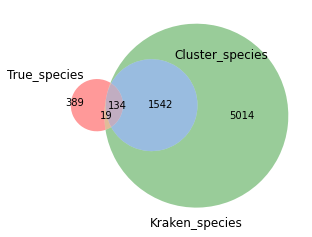

In [7]:
path095="Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_0.95"
result_df095=compute_result(path095)
AnalysisSpecies(result_df095,"species")

## 0.99

In [9]:
! aws s3 cp s3://share.jgi-ga.org/chen-Tax/CAMI2_NonZero_1027/Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_0.99/part-00000 Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_0.99

download: s3://share.jgi-ga.org/chen-Tax/CAMI2_NonZero_1027/Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_0.99/part-00000 to ./Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_0.99


              clusterid  clu_species   labelid  true_taxid true_rank   kra_id  \
readname                                                                        
S19R15616866     284790            0  291950.0     1737424   species  2479767   
S29R2726353      284790            0  184966.0     1796616   species   572511   
S29R3879533      284790            0  172640.1     1121114    strain    33035   
S29R8024613      284790            0  184966.0     1796616   species   572511   
S35R13571826     284790            0  184966.0     1796616   species   572511   

             kra_rank  true_species  kra_species  
readname                                          
S19R15616866  species       1737424      2479767  
S29R2726353     genus       1796616           -1  
S29R3879533   species         33035        33035  
S29R8024613     genus       1796616           -1  
S35R13571826    genus       1796616           -1  
(65007074, 9)
============================Kraken2 Speices Level Result Show

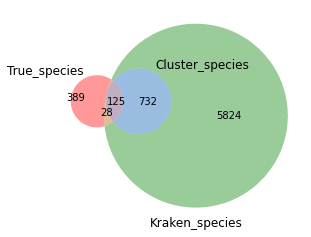

In [10]:
path099="Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_0.99"
result_df099=compute_result(path099)
AnalysisSpecies(result_df099,"species")

## 1.00

In [11]:
! aws s3 cp s3://share.jgi-ga.org/chen-Tax/CAMI2_NonZero_1027/Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_100/part-00000 Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_100

download: s3://share.jgi-ga.org/chen-Tax/CAMI2_NonZero_1027/Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_100/part-00000 to ./Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_100


              clusterid  clu_species    labelid  true_taxid true_rank  kra_id  \
readname                                                                        
S22R10477239      27120            0   192222.0         839   species  264731   
S40R15152995      27120            0  1889556.0       46506   species       0   
S44R5894919       27120            0   192222.0         839   species  264731   
S44R8120399       27120            0   192222.0         839   species     839   
S44R8171369       27120            0   192222.0         839   species  264731   

             kra_rank  true_species  kra_species  
readname                                          
S22R10477239   strain           839          839  
S40R15152995      NaN         46506            0  
S44R5894919    strain           839          839  
S44R8120399   species           839          839  
S44R8171369    strain           839          839  
(65007074, 9)
============================Kraken2 Speices Level Result Show

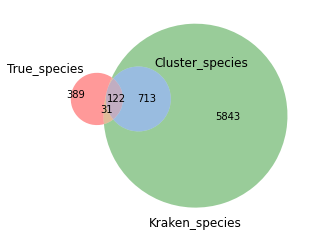

In [12]:
path100="Species_CAMI2_localclustering_filter_kraken2_taxonomy_Unzero_100"
result_df100=compute_result(path100)
AnalysisSpecies(result_df100,"species")